# Setting up the neo4j connection

In [32]:
import pandas as pd 
from neo4j import GraphDatabase
import sqlite3

class Neo4jConnection:
    
    def __init__(self, uri="bolt://localhost:7687", user="neo4j", pwd="chris"):
        self.__uri = uri 
        self.__user = user 
        self.__pwd = pwd
        self. __driver = None 
        try: 
            self.__driver = GraphDatabase.driver(self.__uri, auth=
                                                (self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver: ", e)
    
    
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
    
    
    def query(self, query, db='authors'):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = session.run(query)
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
    
    def delete_all_nodes(self):
        self.query("Match(n) detach delete n")
        return "All nodes deleted"
    
#     def delete_all_edges(self,relationship):
#         return self.query("MATCH (:Author)-[r:relationship]-(:Author) DELETE r")
        
    
    
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="chris")  

##### Importing/cleaning data

In [6]:
conn_sql = sqlite3.connect("../data/pub_raw.db")
authors = pd.read_sql_query("SELECT * FROM author",conn_sql)
authors_list = authors.values.tolist()

# getting middle name out of quotes
authors[authors['id']==3973]
authors_list[3972][4] = 'Marium'
authors_list[3972][4]


'Marium'

# Creating nodes

- Each node represents an author, node attributes consist of columns in the SQL author table (first name, last name, email, etc.) 

### Creating authors node with attributes (not parsed)

- This code creates edged in neo4j

In [513]:
for row in authors_list:
    row[0] = f"'{row[0]}'"
    row[1] = f"'{row[1]}'"
    row[2] = f'"{row[2]}"'
    row[3] = f'"{row[3]}"'
    row[4] = f"'{row[4]}'"
    row[5] = f'"{row[5]}"'
    conn.query("Create (n:Author {id:" 
               + row[0] + ", first_name: " 
               + row[2] + ", last_name: " 
               + row[3] + ", middle_name:" 
               + row[4] + ", email: "
               + row[5] + "})")

### Creating the author nodes with attributes (parsed verion)
 - Use this once the authors-parsed table is fixed 

In [138]:
# authors_parsed = pd.read_csv("../pub-analyzer-master/data/authors-parsed.csv")
# authors_parsed_list = authors_parsed.values.tolist()

# for row in authors_parsed_list:
#     row[0] = f"'{row[0]}'"
#     row[1] = f"'{row[1]}'"
#     row[2] = f"'{row[2]}'"
#     row[3] = f"'{row[3]}'"
#     row[4] = f"'{row[4]}'"
#     row[5] = f"'{row[5]}'"
#     row[6] = f"'{row[6]}'"
#     row[7] = f"'{row[7]}'"
#     row[8] = f"'{row[8]}'"
#     row[9] = f'"{row[9]}"'
#     row[10] = f"'{row[10]}'"
#     conn.query("Create (n:Author {id:" 
#                + row[0] + ", first_name: " 
#                + row[2] + ", last_name: " 
#                + row[3] + ", middle_name:" 
#                + row[4] + ", email: "
#                + row[5] + ", country: " 
#                + row[7] +  ",org: "
#                + row[9] + "})")
    
    
    

# Creating edges
 - edges between nodes(authors) represent co-authorship

In [9]:
# getting the paper_author table from an SQL query 

paper_authors = pd.read_sql_query("SELECT * FROM paper_author", conn_sql)

# query that retrives the unique paper_ids's

distinct_papers = pd.read_sql_query("SELECT distinct paper_id FROM paper_author" , conn_sql)
len(distinct_papers)

4178

In [10]:
# grouping together the authors that worked on a single paper together 

all_author_groups = []
for i in range(1,len(distinct_papers)):
    author_group = paper_authors.loc[(paper_authors['paper_id'] == i ),['author_id']].values.tolist()
    all_author_groups.append(author_group)

# fixing the all_author_groups list to the correct format 

flat_list = []
for group in all_author_groups:
    single_group = []
    for author in group:
        single_group.append(author[0])
    flat_list.append(single_group)
    
all_author_groups = flat_list

# showing what the first 10 groups look like 
print(all_author_groups[0:10])

[[4, 1, 2, 3], [8, 5, 6, 7], [9, 10, 11, 12], [13, 14], [16, 17, 15], [18, 19, 20, 21], [22, 24, 23], [26, 25], [27, 28, 29, 30], [31, 32, 33, 26]]


##### Creating all combinations for each author group 

In [28]:
# showing how the combinations function works
from itertools import combinations

all_edges = []
for group in all_author_groups:
    comb = combinations(group,2)
    for pair in list(comb):
        all_edges.append(pair)
        
print(len(all_edges))
print(all_edges[0:10])

9502
[(4, 1), (4, 2), (4, 3), (1, 2), (1, 3), (2, 3), (8, 5), (8, 6), (8, 7), (5, 6)]


##### Logically testing that 9502 edges is correct 

In [13]:
# total_lenth list gets you the amount of authors in each "author group" or in each paper
total_length = []
for group in all_author_groups:
    length = len(group)
    total_length.append(length)
print(sum(total_length))
pd.Series(total_length).value_counts()

9515


2     1249
3     1216
1      778
4      449
0      340
5      109
6       25
7        5
9        2
15       1
14       1
10       1
8        1
dtype: int64

## Create the edges in neo4j

In [14]:
print("All edges list in a list of tuples")
print(all_edges[0:5])  # list of tuples 
print()


# change the all the edges (relationships) from tuples to lists since we need to pass in a string holding the author id
all_edges_lists = [list(edge) for edge in all_edges] 

print("All edges in a list of lists")
print(all_edges_lists[0:5])


All edges list in a list of tuples
[(4, 1), (4, 2), (4, 3), (1, 2), (1, 3)]

All edges in a list of lists
[[4, 1], [4, 2], [4, 3], [1, 2], [1, 3]]


In [15]:
print(f"Amount of ALL co-authorship parrings: {len(all_edges)}")
print(f"Amount of 1 co-authorship parrings: {len(set(all_edges))}")
print(f"Amount of multiple co-authorship parrings {len(all_edges) - len(set(all_edges))}")

Amount of ALL co-authorship parrings: 9502
Amount of 1 co-authorship parrings: 8967
Amount of multiple co-authorship parrings 535


##### Getting all of the relationships as the keys of a dictionary, and the amount of times they Co-authored as the values

 - the final dictionary "all_edges_dict" is a dictionary where the keys are a unique tuple of all co-authorship pairings, and the values are the amount of times they have co-authored

In [16]:
single_edges = []  # all edges that would have a weight of ONLY 1 
multiple_edges_dict = {} 


for edge in all_edges:
    if edge in single_edges:
        multiple_edges_dict[edge] = multiple_edges_dict.get(edge,1) + 1         
    else:
        single_edges.append(edge)
        
keys = multiple_edges_dict.keys()

for key in keys:
    if key in single_edges:
        single_edges.remove(key)


print(sum(multiple_edges_dict.values()) + len(single_edges))
print(len(all_edges))



9502
9502


In [17]:
# turning the single_edges list to a dictionary 
single_edges_dict = {}

for edge in single_edges:
    single_edges_dict[edge] = 1

In [31]:
# combing the single edges dictionary and the multiple 
all_edges_dict = {}
all_edges_dict.update(single_edges_dict)
all_edges_dict.update(multiple_edges_dict)


# values are the number of edges each node pair has, so the sum of all values should be equall to the length of all edges
sum(all_edges_dict.values())
print("all_edges_dict")
all_edges_dict

all_edges_dict


{(4, 1): 1,
 (4, 2): 1,
 (4, 3): 1,
 (1, 2): 1,
 (1, 3): 1,
 (2, 3): 1,
 (8, 5): 1,
 (8, 6): 1,
 (8, 7): 1,
 (5, 6): 1,
 (5, 7): 1,
 (6, 7): 1,
 (9, 10): 1,
 (9, 11): 1,
 (9, 12): 1,
 (10, 11): 1,
 (10, 12): 1,
 (11, 12): 1,
 (13, 14): 1,
 (16, 17): 1,
 (16, 15): 1,
 (17, 15): 1,
 (18, 19): 1,
 (18, 20): 1,
 (18, 21): 1,
 (19, 20): 1,
 (19, 21): 1,
 (20, 21): 1,
 (22, 24): 1,
 (22, 23): 1,
 (24, 23): 1,
 (26, 25): 1,
 (27, 28): 1,
 (27, 29): 1,
 (27, 30): 1,
 (28, 29): 1,
 (28, 30): 1,
 (29, 30): 1,
 (31, 32): 1,
 (31, 33): 1,
 (31, 26): 1,
 (32, 33): 1,
 (32, 26): 1,
 (33, 26): 1,
 (36, 34): 1,
 (36, 35): 1,
 (34, 35): 1,
 (37, 38): 1,
 (41, 39): 1,
 (41, 40): 1,
 (39, 40): 1,
 (42, 43): 1,
 (42, 44): 1,
 (43, 44): 1,
 (45, 48): 1,
 (45, 46): 1,
 (45, 47): 1,
 (48, 47): 1,
 (46, 47): 1,
 (49, 50): 1,
 (52, 53): 1,
 (54, 55): 1,
 (54, 56): 1,
 (54, 57): 1,
 (55, 56): 1,
 (55, 57): 1,
 (56, 57): 1,
 (58, 60): 1,
 (59, 51): 1,
 (59, 60): 1,
 (51, 60): 1,
 (62, 61): 1,
 (62, 63): 1,
 (61,

##### This code runs the query's to make edges(relationships) in neo4j

In [25]:
edge_weight = [i for i in all_edges_dict.values()]
count = 0 
for node1,node2 in all_edges_dict:
    node1 = f"'{node1}'"   
    node2 = f"'{node2}'" 
    weight = f"'{edge_weight[count]}'" 
    conn.query("Match(a:Author {id:" + node1 + "}),(b:Author {id:" + node2 + "})  Merge (a)-[r:Coauthors {weight:" + weight + "}]->(b)")
    count += 1

### Output

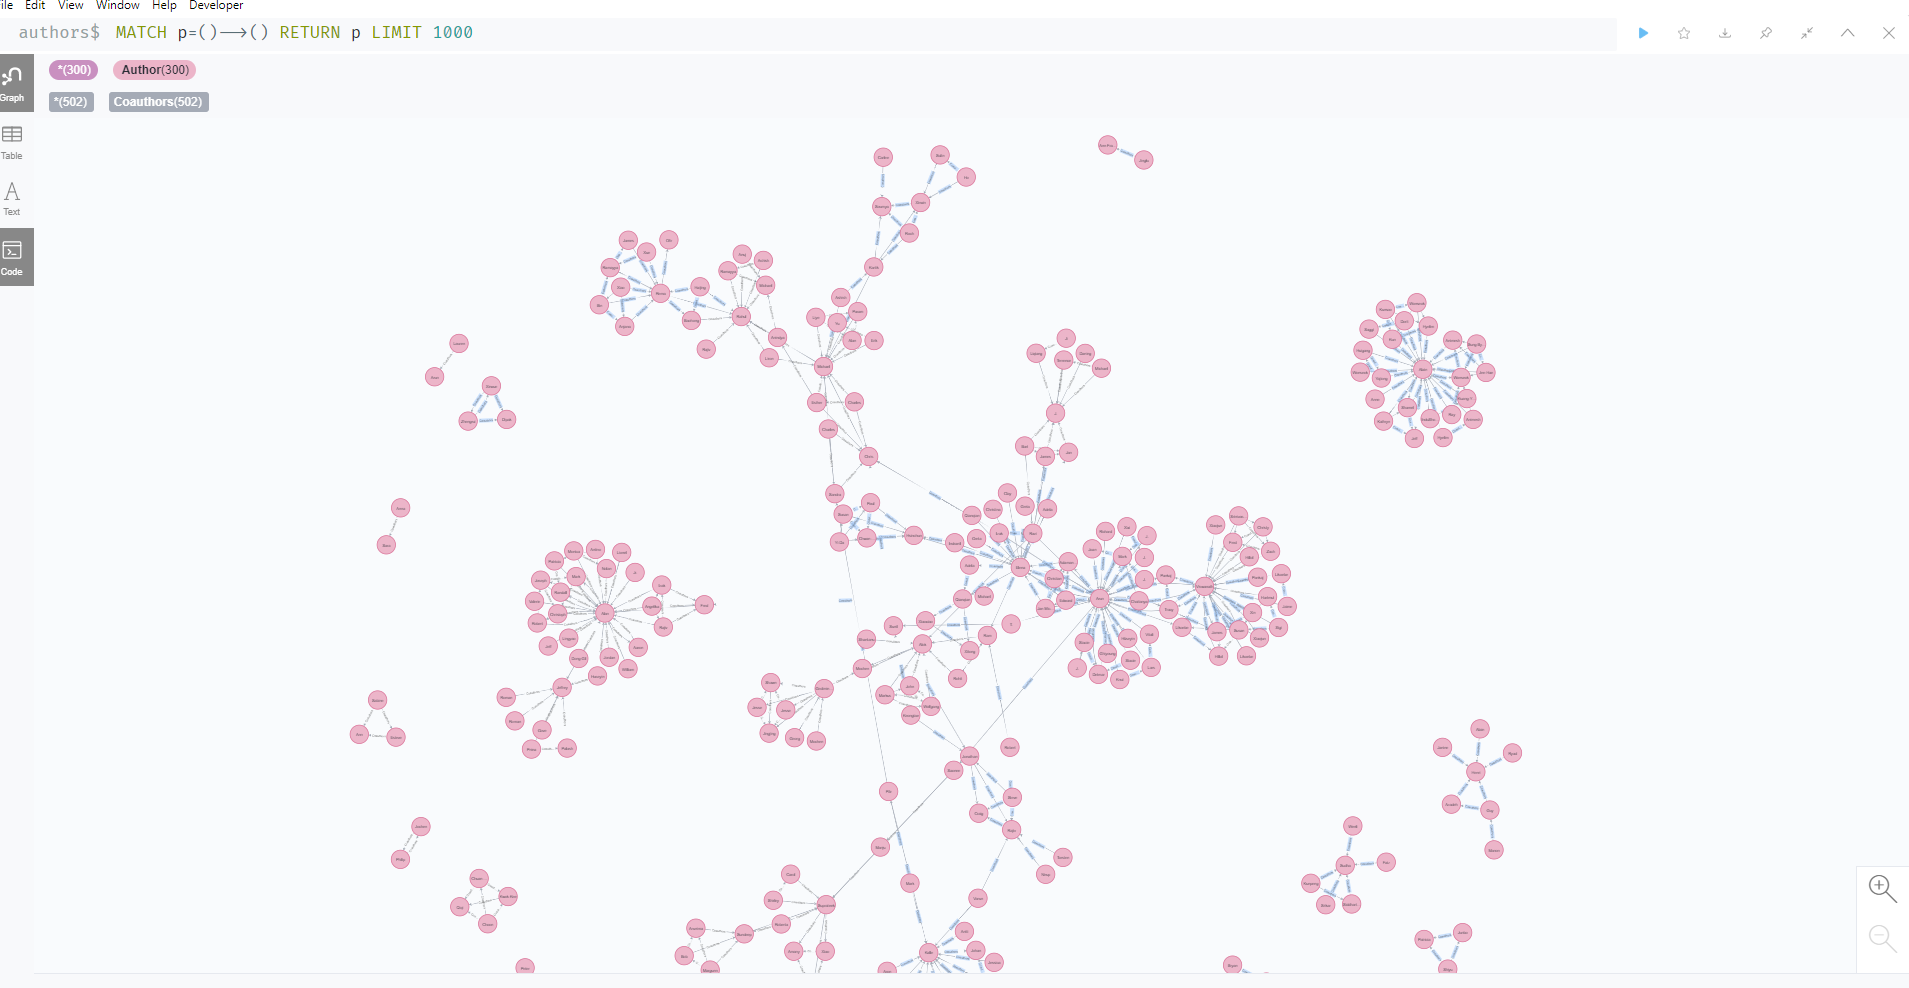